In [1]:
import numpy as np
# import vunet
import vunet_simple as vunet
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import h5py

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [3]:
import tensorflow as tf
from keras import backend as K

# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.85

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

# Load data

In [4]:
output_dir = 'saved_models/'
case_string = 'well_control_128x128'

In [5]:
data_dir = '/data/cees/gegewen/well_control_data/'

hf_r = h5py.File(data_dir + 'train_' + case_string + '_40000.hdf5', 'r')
# hf_r = h5py.File(data_dir + 'train_' + case_string + '_400.hdf5', 'r')
train_x = np.array(hf_r.get('k'))
train_y = np.array(hf_r.get('S'))
hf_r.close()

In [6]:
hf_w = h5py.File(data_dir + 'test_' + case_string + '_8000.hdf5', 'r')
# hf_w = h5py.File(data_dir + 'test_' + case_string + '_80.hdf5', 'r')
test_x = np.array(hf_w.get('k'))
test_y = np.array(hf_w.get('S'))
hf_w.close()

In [7]:
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (40000, 128, 128, 2)
train_y shape is  (40000, 128, 128, 1)
test_x shape is  (8000, 128, 128, 2)
test_y shape is  (8000, 128, 128, 1)


In [8]:
train_x = train_x[:10000, ...]
train_y = train_y[:10000, ...]
test_x = test_x[:100, ...]
test_y = test_y[:100, ...]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape ', test_x.shape)
print('test_y shape ', test_y.shape)

train_x shape is  (10000, 128, 128, 2)
train_y shape is  (10000, 128, 128, 1)
test_x shape  (100, 128, 128, 2)
test_y shape  (100, 128, 128, 1)


### Plot training dataset

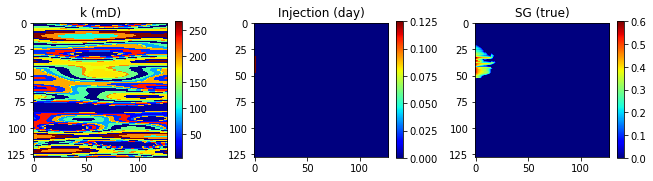

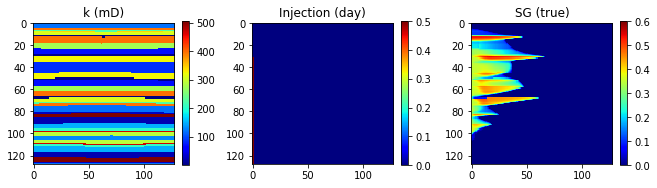

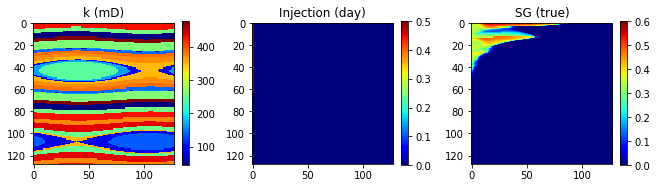

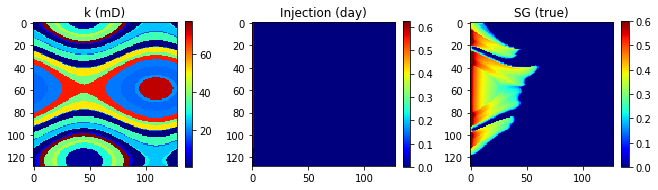

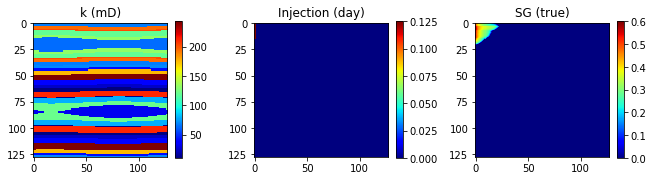

In [11]:
for k in range(5):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(train_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plot_k = train_x[k, :, :, 1]
    plt.imshow(plot_k)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    plt.title('SG (true)')
    plt.imshow(train_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)

    plt.tight_layout()
    plt.show()

### Plot test dataset

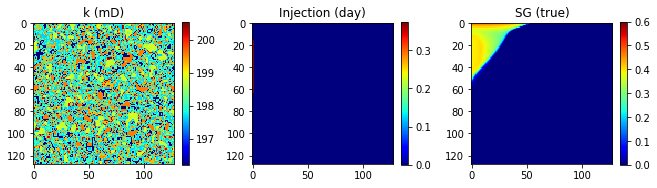

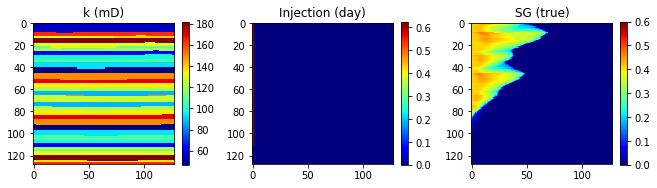

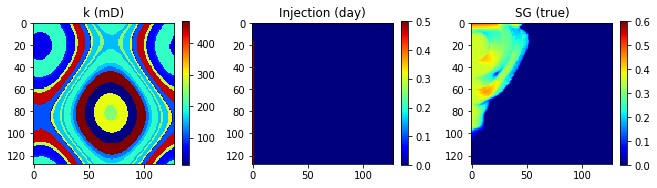

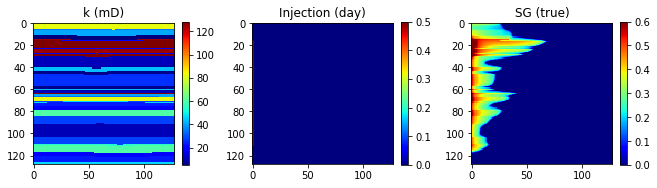

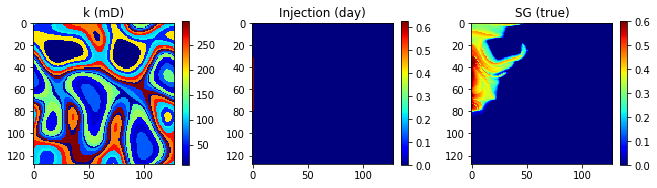

In [13]:
for k in range(5):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(test_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plot_k = test_x[k, :, :, 1]
    plt.imshow(plot_k)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    plt.title('SG (true)')
    plt.imshow(test_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    

    plt.tight_layout()
    plt.show()

# Training starts here
### Bypass this part if you only want test

In [18]:
# from importlib import reload
# reload(vunet)

<module 'vunet_simple' from '/data/cees/zjin/cs231n/project/var-unet/vunet_simple.py'>

In [9]:
input_shape = (128, 128, 2)
output_shape = (128, 128, 1)

In [10]:
## Original v-unet implementation
# enc_up, hidden_shapes = vunet.create_enc_up(input_shape, n_scales = 5, n_res_blk = 1)
# # enc_up.summary()

# latent_shape = hidden_shapes[-1]

# enc_down = vunet.create_enc_down(latent_shape)
# # enc_down.summary()

# dec_up = vunet.create_dec_up(output_shape, n_scales = 5, n_res_blk = 1) # only c input
# # dec_up.summary()

# dec_down = vunet.create_dec_down(hidden_shapes, latent_shape, n_scales = 5, n_res_blk = 1)
# # dec_down.summary()

In [11]:
# change the role of enc_up and dec_up
enc_up, hidden_shapes = vunet.create_enc_up(output_shape, n_scales = 5)
enc_down = vunet.create_enc_down(hidden_shapes[-1])
dec_up = vunet.create_dec_up(input_shape, n_scales = 5) # only c input
dec_down = vunet.create_dec_down(hidden_shapes, hidden_shapes[-1], n_scales = 5)

#### Train forward pass v-unet

In [40]:
# xc = Input(shape=input_shape) # perm + well location
# c = Input(shape=output_shape) # well location

# hs = enc_up(xc)
# z_posterior_sample, z_posterior_mean = enc_down(hs[-1])
# gs = dec_up(c)
# # x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_sample, *gs])
# x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_mean, *gs])

In [12]:
xc = Input(shape=input_shape) # perm + well location
c = Input(shape=output_shape) # well location

hs = enc_up(c)
z_posterior_sample, z_posterior_mean = enc_down(hs[-1])
gs = dec_up(xc)
x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_mean, *gs])

In [13]:
def likelihood_loss(x, x_hat):
    '''
    Reconstruction loss, L2 norm
    
    '''
    v = 0.1
    return K.mean(K.sum((K.batch_flatten(x) - K.batch_flatten(x_hat)) ** 2 / (2*v), axis=-1))

def latent_kl_loss(q, p):
    mean1 = q
    mean2 = p
    
    kl = 0.5 * (mean2 - mean1)**2
    kl = K.sum(kl, axis = [1,2,3])
    kl = K.mean(kl)
    return kl

In [14]:
x = Input(shape=output_shape) # target saturation

likelihood_loss_value = likelihood_loss(x, x_hat)
kl_loss = latent_kl_loss(z_posterior_mean, z_piror_mean)
kl_weight = 5.0
total_loss = likelihood_loss_value + kl_weight * kl_loss


In [16]:
epoch = 150
learning_rate = 5e-4
train_nr = train_x.shape[0]
test_nr = test_x.shape[0]
batch_size = 16
num_batch = int(train_nr/batch_size) 


In [17]:
opt = Adam(lr=learning_rate)

trainable_weights = enc_up.trainable_weights + enc_down.trainable_weights + dec_up.trainable_weights + dec_down.trainable_weights

updates = opt.get_updates(total_loss, trainable_weights)

iterate = K.function([xc, c, x], [total_loss, likelihood_loss_value, kl_loss], updates=updates)

eval_loss = K.function([xc, c, x], [total_loss])


In [18]:
train_loss_record = []
test_loss_record =[]

for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        x_batch = train_x[ind0:ind0+batch_size, ...]
        y_batch = train_y[ind0:ind0+batch_size, ...]
        
        train_losses = iterate([x_batch, x_batch[:,:,:,[1]], y_batch])
#         print(train_losses)
        if ib % 100 == 0:
            print('Epoch %d/%d, Batch %d/%d, Total Loss %f, Likelihood Loss %f, KL Loss %f' % (e+1, epoch, ib+1, num_batch, train_losses[0], train_losses[1], train_losses[2]))
        
        eval_losses = eval_loss([test_x, test_x[:,:,:,[1]], test_y])
        
    train_loss_record.append(train_losses[0])
    test_loss_record.append(eval_losses[0])
    
    print('====================================================')
    print('\n')
    print('Epoch %d/%d, Train Total Loss %f, Eval Total Loss %f' % (e + 1, epoch, train_losses[0], eval_losses[0]))
    print('\n')
    print('====================================================')
enc_up.save_weights(output_dir + 'enc_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
enc_down.save_weights(output_dir + 'enc_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_up.save_weights(output_dir + 'dec_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_down.save_weights(output_dir + 'dec_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))

Epoch 1/150, Batch 1/625, Total Loss 3773.170166, Likelihood Loss 3770.324463, KL Loss 0.569148
Epoch 1/150, Batch 101/625, Total Loss 433.230896, Likelihood Loss 428.707245, KL Loss 0.904728
Epoch 1/150, Batch 201/625, Total Loss 194.274048, Likelihood Loss 192.279724, KL Loss 0.398866
Epoch 1/150, Batch 301/625, Total Loss 115.707779, Likelihood Loss 114.138023, KL Loss 0.313951
Epoch 1/150, Batch 401/625, Total Loss 141.540268, Likelihood Loss 139.697754, KL Loss 0.368503
Epoch 1/150, Batch 501/625, Total Loss 114.769173, Likelihood Loss 113.275635, KL Loss 0.298707
Epoch 1/150, Batch 601/625, Total Loss 103.760284, Likelihood Loss 101.950455, KL Loss 0.361965


Epoch 1/150, Train Total Loss 100.341141, Eval Total Loss 130.092026


Epoch 2/150, Batch 1/625, Total Loss 126.689270, Likelihood Loss 124.836197, KL Loss 0.370614
Epoch 2/150, Batch 101/625, Total Loss 148.630203, Likelihood Loss 147.026215, KL Loss 0.320797
Epoch 2/150, Batch 201/625, Total Loss 79.713608, Likelihood Loss

Epoch 11/150, Batch 101/625, Total Loss 29.297905, Likelihood Loss 28.034449, KL Loss 0.252691
Epoch 11/150, Batch 201/625, Total Loss 20.901123, Likelihood Loss 19.759523, KL Loss 0.228320
Epoch 11/150, Batch 301/625, Total Loss 20.194551, Likelihood Loss 19.448315, KL Loss 0.149247
Epoch 11/150, Batch 401/625, Total Loss 27.042662, Likelihood Loss 25.865589, KL Loss 0.235415
Epoch 11/150, Batch 501/625, Total Loss 19.735676, Likelihood Loss 18.875221, KL Loss 0.172091
Epoch 11/150, Batch 601/625, Total Loss 29.655403, Likelihood Loss 28.263033, KL Loss 0.278474


Epoch 11/150, Train Total Loss 38.529266, Eval Total Loss 38.281937


Epoch 12/150, Batch 1/625, Total Loss 35.259052, Likelihood Loss 33.651421, KL Loss 0.321526
Epoch 12/150, Batch 101/625, Total Loss 24.927351, Likelihood Loss 23.668732, KL Loss 0.251724
Epoch 12/150, Batch 201/625, Total Loss 19.409929, Likelihood Loss 18.311676, KL Loss 0.219651
Epoch 12/150, Batch 301/625, Total Loss 18.476408, Likelihood Loss 17.78143

Epoch 21/150, Batch 101/625, Total Loss 18.907694, Likelihood Loss 17.763283, KL Loss 0.228882
Epoch 21/150, Batch 201/625, Total Loss 18.755201, Likelihood Loss 17.551157, KL Loss 0.240809
Epoch 21/150, Batch 301/625, Total Loss 16.402502, Likelihood Loss 15.820759, KL Loss 0.116349
Epoch 21/150, Batch 401/625, Total Loss 33.346008, Likelihood Loss 32.332680, KL Loss 0.202666
Epoch 21/150, Batch 501/625, Total Loss 16.316261, Likelihood Loss 15.454638, KL Loss 0.172325
Epoch 21/150, Batch 601/625, Total Loss 17.153936, Likelihood Loss 16.203075, KL Loss 0.190172


Epoch 21/150, Train Total Loss 19.468699, Eval Total Loss 22.708790


Epoch 22/150, Batch 1/625, Total Loss 18.231300, Likelihood Loss 17.000931, KL Loss 0.246074
Epoch 22/150, Batch 101/625, Total Loss 15.946901, Likelihood Loss 14.876566, KL Loss 0.214067
Epoch 22/150, Batch 201/625, Total Loss 14.899160, Likelihood Loss 13.865139, KL Loss 0.206804
Epoch 22/150, Batch 301/625, Total Loss 16.768581, Likelihood Loss 16.13160

Epoch 31/150, Batch 101/625, Total Loss 14.104782, Likelihood Loss 13.179243, KL Loss 0.185108
Epoch 31/150, Batch 201/625, Total Loss 15.031044, Likelihood Loss 14.141636, KL Loss 0.177882
Epoch 31/150, Batch 301/625, Total Loss 13.007724, Likelihood Loss 12.501884, KL Loss 0.101168
Epoch 31/150, Batch 401/625, Total Loss 14.952838, Likelihood Loss 14.116312, KL Loss 0.167305
Epoch 31/150, Batch 501/625, Total Loss 16.121622, Likelihood Loss 15.446722, KL Loss 0.134980
Epoch 31/150, Batch 601/625, Total Loss 19.147209, Likelihood Loss 18.270992, KL Loss 0.175244


Epoch 31/150, Train Total Loss 15.834900, Eval Total Loss 21.026670


Epoch 32/150, Batch 1/625, Total Loss 15.230461, Likelihood Loss 14.191191, KL Loss 0.207854
Epoch 32/150, Batch 101/625, Total Loss 14.905025, Likelihood Loss 13.921006, KL Loss 0.196804
Epoch 32/150, Batch 201/625, Total Loss 17.484177, Likelihood Loss 16.573275, KL Loss 0.182180
Epoch 32/150, Batch 301/625, Total Loss 13.028795, Likelihood Loss 12.44224

Epoch 41/150, Batch 101/625, Total Loss 11.797513, Likelihood Loss 10.918125, KL Loss 0.175878
Epoch 41/150, Batch 201/625, Total Loss 13.607539, Likelihood Loss 12.788910, KL Loss 0.163726
Epoch 41/150, Batch 301/625, Total Loss 8.646347, Likelihood Loss 8.208112, KL Loss 0.087647
Epoch 41/150, Batch 401/625, Total Loss 13.246800, Likelihood Loss 12.552280, KL Loss 0.138904
Epoch 41/150, Batch 501/625, Total Loss 10.602931, Likelihood Loss 9.983479, KL Loss 0.123890
Epoch 41/150, Batch 601/625, Total Loss 17.413485, Likelihood Loss 16.615116, KL Loss 0.159674


Epoch 41/150, Train Total Loss 12.197075, Eval Total Loss 20.330872


Epoch 42/150, Batch 1/625, Total Loss 14.221911, Likelihood Loss 13.316892, KL Loss 0.181004
Epoch 42/150, Batch 101/625, Total Loss 14.088880, Likelihood Loss 13.250265, KL Loss 0.167723
Epoch 42/150, Batch 201/625, Total Loss 10.362094, Likelihood Loss 9.578893, KL Loss 0.156640
Epoch 42/150, Batch 301/625, Total Loss 9.925463, Likelihood Loss 9.478607, KL 

Epoch 51/150, Batch 101/625, Total Loss 13.129699, Likelihood Loss 12.323299, KL Loss 0.161280
Epoch 51/150, Batch 201/625, Total Loss 8.782230, Likelihood Loss 8.166866, KL Loss 0.123073
Epoch 51/150, Batch 301/625, Total Loss 9.102365, Likelihood Loss 8.681735, KL Loss 0.084126
Epoch 51/150, Batch 401/625, Total Loss 12.807190, Likelihood Loss 12.187225, KL Loss 0.123993
Epoch 51/150, Batch 501/625, Total Loss 10.129390, Likelihood Loss 9.639185, KL Loss 0.098041
Epoch 51/150, Batch 601/625, Total Loss 10.353143, Likelihood Loss 9.758753, KL Loss 0.118878


Epoch 51/150, Train Total Loss 12.270246, Eval Total Loss 16.913326


Epoch 52/150, Batch 1/625, Total Loss 13.595456, Likelihood Loss 12.872336, KL Loss 0.144624
Epoch 52/150, Batch 101/625, Total Loss 8.910452, Likelihood Loss 8.243067, KL Loss 0.133477
Epoch 52/150, Batch 201/625, Total Loss 11.191721, Likelihood Loss 10.562396, KL Loss 0.125865
Epoch 52/150, Batch 301/625, Total Loss 9.257760, Likelihood Loss 8.832391, KL Loss

Epoch 61/150, Batch 101/625, Total Loss 10.852791, Likelihood Loss 10.188137, KL Loss 0.132931
Epoch 61/150, Batch 201/625, Total Loss 10.361207, Likelihood Loss 9.722828, KL Loss 0.127676
Epoch 61/150, Batch 301/625, Total Loss 11.822648, Likelihood Loss 11.386686, KL Loss 0.087192
Epoch 61/150, Batch 401/625, Total Loss 10.770405, Likelihood Loss 10.192229, KL Loss 0.115635
Epoch 61/150, Batch 501/625, Total Loss 11.789886, Likelihood Loss 11.256899, KL Loss 0.106598
Epoch 61/150, Batch 601/625, Total Loss 8.763777, Likelihood Loss 8.194156, KL Loss 0.113924


Epoch 61/150, Train Total Loss 11.412917, Eval Total Loss 16.056755


Epoch 62/150, Batch 1/625, Total Loss 11.497040, Likelihood Loss 10.811778, KL Loss 0.137052
Epoch 62/150, Batch 101/625, Total Loss 11.270609, Likelihood Loss 10.660363, KL Loss 0.122049
Epoch 62/150, Batch 201/625, Total Loss 8.592904, Likelihood Loss 7.988775, KL Loss 0.120826
Epoch 62/150, Batch 301/625, Total Loss 12.686599, Likelihood Loss 12.298904, KL

Epoch 71/150, Batch 101/625, Total Loss 10.739428, Likelihood Loss 10.155122, KL Loss 0.116861
Epoch 71/150, Batch 201/625, Total Loss 8.380261, Likelihood Loss 7.866513, KL Loss 0.102750
Epoch 71/150, Batch 301/625, Total Loss 9.511843, Likelihood Loss 9.195074, KL Loss 0.063354
Epoch 71/150, Batch 401/625, Total Loss 9.486840, Likelihood Loss 8.980161, KL Loss 0.101336
Epoch 71/150, Batch 501/625, Total Loss 7.692785, Likelihood Loss 7.289207, KL Loss 0.080715
Epoch 71/150, Batch 601/625, Total Loss 10.846062, Likelihood Loss 10.379902, KL Loss 0.093232


Epoch 71/150, Train Total Loss 9.545401, Eval Total Loss 14.031219


Epoch 72/150, Batch 1/625, Total Loss 9.115081, Likelihood Loss 8.545527, KL Loss 0.113911
Epoch 72/150, Batch 101/625, Total Loss 9.612865, Likelihood Loss 9.049132, KL Loss 0.112747
Epoch 72/150, Batch 201/625, Total Loss 6.967494, Likelihood Loss 6.442770, KL Loss 0.104945
Epoch 72/150, Batch 301/625, Total Loss 6.370842, Likelihood Loss 6.005091, KL Loss 0.0731

Epoch 81/150, Batch 101/625, Total Loss 8.785913, Likelihood Loss 8.283092, KL Loss 0.100564
Epoch 81/150, Batch 201/625, Total Loss 8.442259, Likelihood Loss 7.947958, KL Loss 0.098860
Epoch 81/150, Batch 301/625, Total Loss 7.397668, Likelihood Loss 7.074008, KL Loss 0.064732
Epoch 81/150, Batch 401/625, Total Loss 12.051490, Likelihood Loss 11.568599, KL Loss 0.096578
Epoch 81/150, Batch 501/625, Total Loss 8.001694, Likelihood Loss 7.588011, KL Loss 0.082737
Epoch 81/150, Batch 601/625, Total Loss 12.081487, Likelihood Loss 11.544931, KL Loss 0.107311


Epoch 81/150, Train Total Loss 9.490386, Eval Total Loss 13.919737


Epoch 82/150, Batch 1/625, Total Loss 9.498358, Likelihood Loss 8.916670, KL Loss 0.116338
Epoch 82/150, Batch 101/625, Total Loss 11.971901, Likelihood Loss 11.461393, KL Loss 0.102101
Epoch 82/150, Batch 201/625, Total Loss 8.241652, Likelihood Loss 7.728636, KL Loss 0.102603
Epoch 82/150, Batch 301/625, Total Loss 10.426801, Likelihood Loss 10.113794, KL Loss 0.

Epoch 91/150, Batch 101/625, Total Loss 6.595208, Likelihood Loss 6.163499, KL Loss 0.086342
Epoch 91/150, Batch 201/625, Total Loss 7.704722, Likelihood Loss 7.296570, KL Loss 0.081630
Epoch 91/150, Batch 301/625, Total Loss 6.051104, Likelihood Loss 5.818346, KL Loss 0.046552
Epoch 91/150, Batch 401/625, Total Loss 7.034635, Likelihood Loss 6.680795, KL Loss 0.070768
Epoch 91/150, Batch 501/625, Total Loss 6.459963, Likelihood Loss 6.146464, KL Loss 0.062700
Epoch 91/150, Batch 601/625, Total Loss 7.536684, Likelihood Loss 7.170531, KL Loss 0.073231


Epoch 91/150, Train Total Loss 7.043102, Eval Total Loss 12.757518


Epoch 92/150, Batch 1/625, Total Loss 6.988310, Likelihood Loss 6.579094, KL Loss 0.081843
Epoch 92/150, Batch 101/625, Total Loss 6.233000, Likelihood Loss 5.837535, KL Loss 0.079093
Epoch 92/150, Batch 201/625, Total Loss 7.017661, Likelihood Loss 6.644434, KL Loss 0.074645
Epoch 92/150, Batch 301/625, Total Loss 5.335946, Likelihood Loss 5.091323, KL Loss 0.048925
E

Epoch 101/150, Batch 101/625, Total Loss 5.747090, Likelihood Loss 5.379546, KL Loss 0.073509
Epoch 101/150, Batch 201/625, Total Loss 4.868575, Likelihood Loss 4.519235, KL Loss 0.069868
Epoch 101/150, Batch 301/625, Total Loss 6.774990, Likelihood Loss 6.528217, KL Loss 0.049355
Epoch 101/150, Batch 401/625, Total Loss 8.238458, Likelihood Loss 7.876949, KL Loss 0.072302
Epoch 101/150, Batch 501/625, Total Loss 7.493351, Likelihood Loss 7.190605, KL Loss 0.060549
Epoch 101/150, Batch 601/625, Total Loss 7.129322, Likelihood Loss 6.734194, KL Loss 0.079025


Epoch 101/150, Train Total Loss 6.743046, Eval Total Loss 12.566212


Epoch 102/150, Batch 1/625, Total Loss 6.407210, Likelihood Loss 6.013964, KL Loss 0.078649
Epoch 102/150, Batch 101/625, Total Loss 7.113596, Likelihood Loss 6.752226, KL Loss 0.072274
Epoch 102/150, Batch 201/625, Total Loss 7.271309, Likelihood Loss 6.895873, KL Loss 0.075087
Epoch 102/150, Batch 301/625, Total Loss 7.291335, Likelihood Loss 7.040534, KL Loss

Epoch 111/150, Batch 101/625, Total Loss 7.451475, Likelihood Loss 7.118764, KL Loss 0.066542
Epoch 111/150, Batch 201/625, Total Loss 10.272485, Likelihood Loss 9.884581, KL Loss 0.077581
Epoch 111/150, Batch 301/625, Total Loss 8.848864, Likelihood Loss 8.606254, KL Loss 0.048522
Epoch 111/150, Batch 401/625, Total Loss 8.738513, Likelihood Loss 8.377193, KL Loss 0.072264
Epoch 111/150, Batch 501/625, Total Loss 7.295704, Likelihood Loss 6.995833, KL Loss 0.059974
Epoch 111/150, Batch 601/625, Total Loss 5.677353, Likelihood Loss 5.322502, KL Loss 0.070970


Epoch 111/150, Train Total Loss 8.496471, Eval Total Loss 13.112415


Epoch 112/150, Batch 1/625, Total Loss 7.312412, Likelihood Loss 6.950438, KL Loss 0.072395
Epoch 112/150, Batch 101/625, Total Loss 6.709480, Likelihood Loss 6.368527, KL Loss 0.068191
Epoch 112/150, Batch 201/625, Total Loss 9.295524, Likelihood Loss 8.932066, KL Loss 0.072692
Epoch 112/150, Batch 301/625, Total Loss 6.583805, Likelihood Loss 6.314605, KL Los

Epoch 121/150, Batch 101/625, Total Loss 7.205739, Likelihood Loss 6.892977, KL Loss 0.062552
Epoch 121/150, Batch 201/625, Total Loss 7.468856, Likelihood Loss 7.152508, KL Loss 0.063270
Epoch 121/150, Batch 301/625, Total Loss 6.332908, Likelihood Loss 6.074787, KL Loss 0.051624
Epoch 121/150, Batch 401/625, Total Loss 7.336913, Likelihood Loss 7.019432, KL Loss 0.063496
Epoch 121/150, Batch 501/625, Total Loss 6.884170, Likelihood Loss 6.615541, KL Loss 0.053726
Epoch 121/150, Batch 601/625, Total Loss 5.078525, Likelihood Loss 4.757866, KL Loss 0.064132


Epoch 121/150, Train Total Loss 6.527659, Eval Total Loss 12.191040


Epoch 122/150, Batch 1/625, Total Loss 7.344024, Likelihood Loss 6.980666, KL Loss 0.072672
Epoch 122/150, Batch 101/625, Total Loss 5.824536, Likelihood Loss 5.517376, KL Loss 0.061432
Epoch 122/150, Batch 201/625, Total Loss 7.177025, Likelihood Loss 6.848315, KL Loss 0.065742
Epoch 122/150, Batch 301/625, Total Loss 5.942686, Likelihood Loss 5.731269, KL Loss

Epoch 131/150, Batch 101/625, Total Loss 5.478892, Likelihood Loss 5.192578, KL Loss 0.057263
Epoch 131/150, Batch 201/625, Total Loss 5.658596, Likelihood Loss 5.386838, KL Loss 0.054352
Epoch 131/150, Batch 301/625, Total Loss 5.029014, Likelihood Loss 4.824237, KL Loss 0.040955
Epoch 131/150, Batch 401/625, Total Loss 7.179935, Likelihood Loss 6.883474, KL Loss 0.059292
Epoch 131/150, Batch 501/625, Total Loss 6.203148, Likelihood Loss 5.938553, KL Loss 0.052919
Epoch 131/150, Batch 601/625, Total Loss 5.807434, Likelihood Loss 5.511447, KL Loss 0.059197


Epoch 131/150, Train Total Loss 8.120465, Eval Total Loss 17.540649


Epoch 132/150, Batch 1/625, Total Loss 7.416672, Likelihood Loss 7.074925, KL Loss 0.068349
Epoch 132/150, Batch 101/625, Total Loss 5.108762, Likelihood Loss 4.795563, KL Loss 0.062640
Epoch 132/150, Batch 201/625, Total Loss 5.703285, Likelihood Loss 5.405931, KL Loss 0.059471
Epoch 132/150, Batch 301/625, Total Loss 5.931781, Likelihood Loss 5.730302, KL Loss

Epoch 141/150, Batch 101/625, Total Loss 4.946618, Likelihood Loss 4.677711, KL Loss 0.053782
Epoch 141/150, Batch 201/625, Total Loss 4.780325, Likelihood Loss 4.511683, KL Loss 0.053729
Epoch 141/150, Batch 301/625, Total Loss 5.739858, Likelihood Loss 5.537724, KL Loss 0.040427
Epoch 141/150, Batch 401/625, Total Loss 5.533346, Likelihood Loss 5.263679, KL Loss 0.053934
Epoch 141/150, Batch 501/625, Total Loss 6.140543, Likelihood Loss 5.892221, KL Loss 0.049664
Epoch 141/150, Batch 601/625, Total Loss 8.133225, Likelihood Loss 7.835295, KL Loss 0.059586


Epoch 141/150, Train Total Loss 4.962464, Eval Total Loss 12.275375


Epoch 142/150, Batch 1/625, Total Loss 5.943270, Likelihood Loss 5.633817, KL Loss 0.061890
Epoch 142/150, Batch 101/625, Total Loss 5.336153, Likelihood Loss 5.051824, KL Loss 0.056866
Epoch 142/150, Batch 201/625, Total Loss 4.448485, Likelihood Loss 4.185074, KL Loss 0.052682
Epoch 142/150, Batch 301/625, Total Loss 5.753167, Likelihood Loss 5.552305, KL Loss

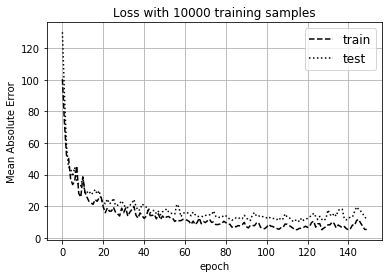

In [31]:
# Data for plotting
fig, ax = plt.subplots()
ax.plot(range(epoch), train_loss_record,  'k--', label='train')
ax.plot(range(epoch), test_loss_record,  'k:', label='test')


legend = ax.legend(loc='upper right', fontsize='large')

ax.set(xlabel='epoch', ylabel='Mean Absolute Error',
        title='Loss with %d training samples' % (train_x.shape[0]))
ax.grid()

fig.savefig("figs/vunet_loss_%dtrain.pdf"%(train_x.shape[0]), format='pdf')
plt.show()

In [53]:
print(train_loss_record[-1])
print(test_loss_record[-1])

5.2069726
11.631281


# Test starts here

### Do not need to run training section

In [21]:
epoch = 150
learning_rate = 5e-4
train_nr = train_x.shape[0]
test_nr = test_x.shape[0]

input_shape = (128,128,2)
output_shape = (128,128,1)


# enc_up, hidden_shapes = vunet.create_enc_up(input_shape, n_scales = 8)
# enc_down = vunet.create_enc_down(latent_shape)
# dec_up = vunet.create_dec_up(output_shape, n_scales = 8) # only c input
# dec_down = vunet.create_dec_down(hidden_shapes, latent_shape, n_scales = 8)

enc_up, hidden_shapes = vunet.create_enc_up(output_shape, n_scales = 5)
enc_down = vunet.create_enc_down(hidden_shapes[-1])
dec_up = vunet.create_dec_up(input_shape, n_scales = 5) # only c input
dec_down = vunet.create_dec_down(hidden_shapes, hidden_shapes[-1], n_scales = 5)

enc_up.load_weights(output_dir + 'enc_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
enc_down.load_weights(output_dir + 'enc_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_up.load_weights(output_dir + 'dec_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_down.load_weights(output_dir + 'dec_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))

#### Transfer forward pass (the only test task we care about)

In [21]:
# xc = Input(shape=input_shape) # perm + well location
# c = Input(shape=(128,128,1)) # well location

# hs = enc_up(xc)
# z_posterior_sample, z_posterior_mean = enc_down(hs[-1])
# gs = dec_up(c)
# x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_mean, *gs])

# v_unet_model = Model([xc, c], [x_hat])

In [22]:
xc = Input(shape=input_shape) # perm + well location
c = Input(shape=(128,128,1)) # well location

hs = enc_up(c)
z_posterior_sample, z_posterior_mean = enc_down(hs[-1])
gs = dec_up(xc)
x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_mean, *gs])

v_unet_model = Model([xc, c], [x_hat])

In [23]:
sat_pred_eval = v_unet_model.predict([test_x, test_x[:,:,:,[1]]])
sat_pred_eval.shape

(100, 128, 128, 1)

In [44]:
sat_pred_train = v_unet_model.predict([train_x[:1000,...], train_x[:1000,:,:,[1]]])
sat_pred_train.shape

(1000, 128, 128, 1)

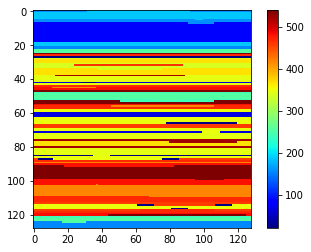

In [25]:
num_test = 7
k_fig = plt.figure()
plt.imshow(test_x[num_test,:,:,0]*1000)
plt.colorbar(fraction=0.046)

In [ ]:
# num_test = 7

# for i in range(16):
#     fig = plt.figure(figsize=(15,3))
#     plt.set_cmap('gray')
    
#     plt.subplot(1,3,1)
#     plt.imshow(vae_weights[0][:,:,0,i])
#     plt.colorbar(fraction=0.046)
# #     plt.clim([-0.1, 0.1])

#     plt.subplot(1,3,2)
#     plt.imshow(vae_weights[0][:,:,1,i])
#     plt.colorbar(fraction=0.046)
# #     plt.clim([-0.1, 0.1])

#     plt.subplot(1,3,3)
# #     plt.set_cmap('jet')
#     plt.imshow(sat_pred_eval[0][num_test,:,:,i])
#     plt.colorbar(fraction=0.046)
# #     fig.savefig('layer1'+'channel'+str(i)+'.png')


/data3/Astro/global/miniconda3/envs/tf-1.10.0/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

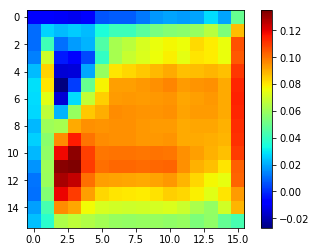

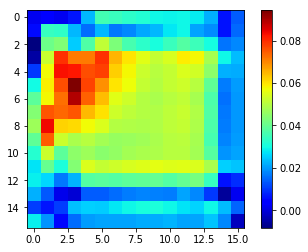

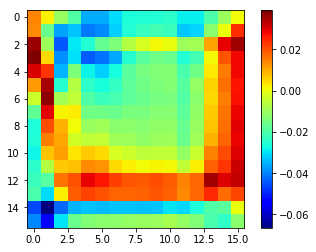

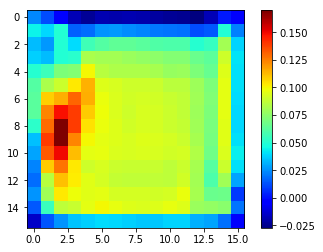

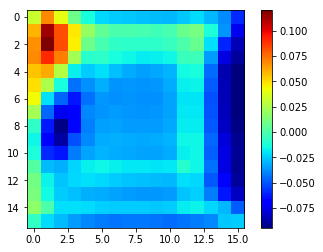

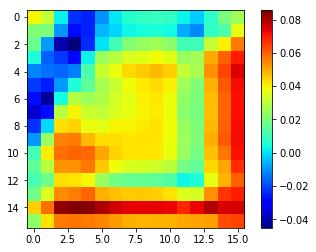

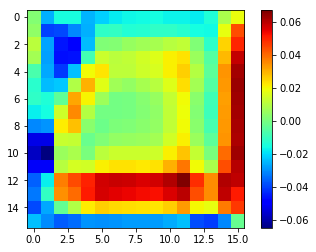

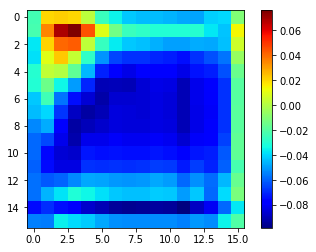

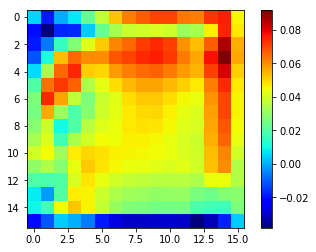

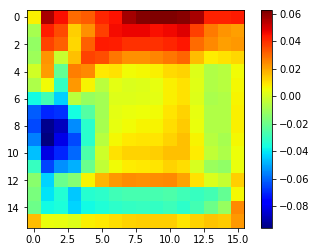

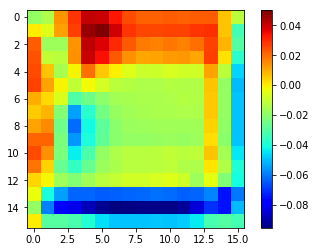

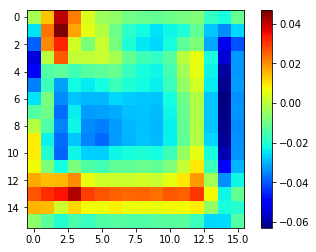

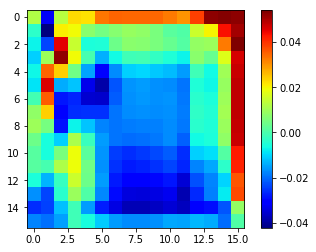

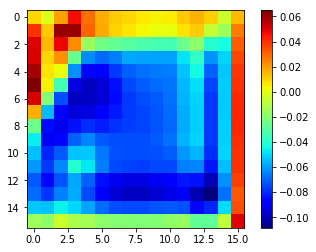

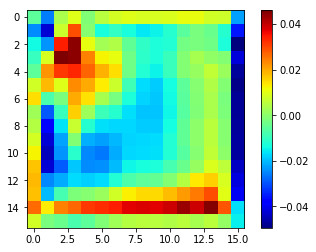

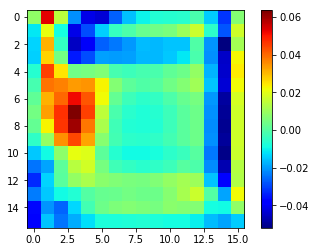

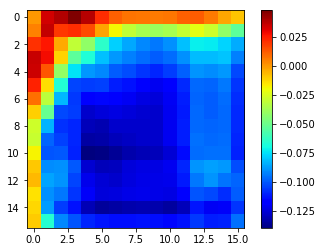

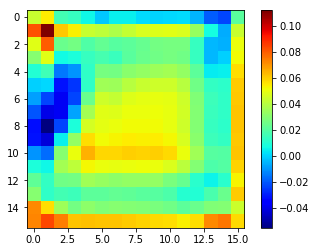

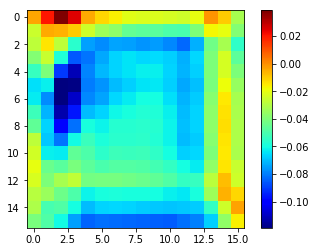

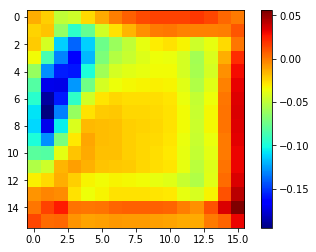

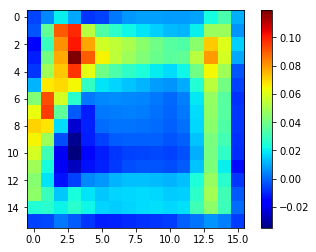

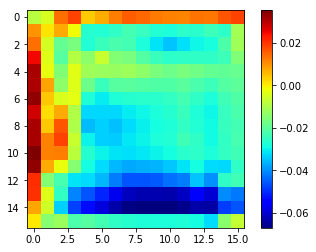

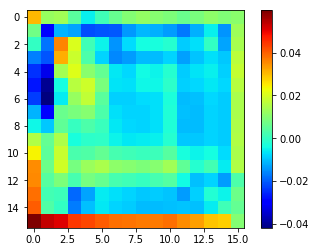

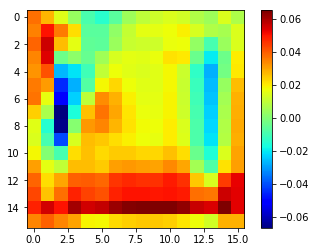

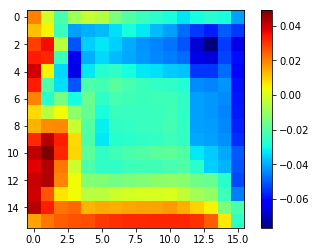

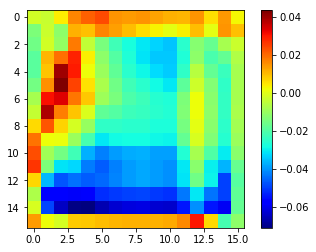

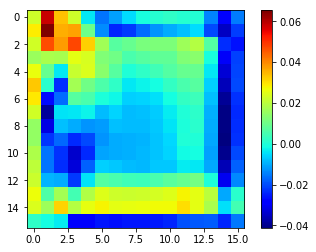

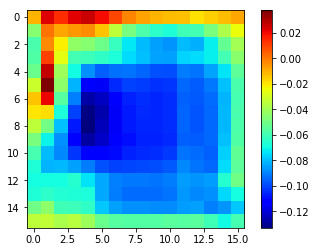

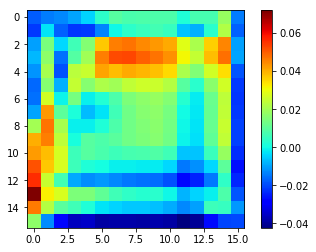

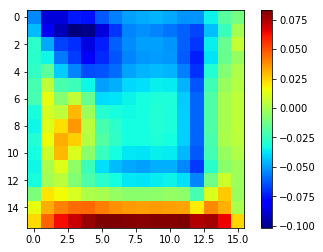

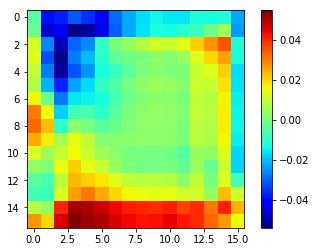

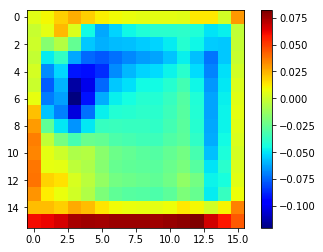

In [17]:
# plt.set_cmap('jet')
# # k_fig = plt.figure()
# # plt.imshow(test_x[0,:,:,0])
# # plt.colorbar(fraction=0.046)
# # k_fig.savefig('k.png')
# layer = 11
# for i in range(32):
#     fig = plt.figure()
#     plt.imshow(sat_pred_eval[layer-1][0,:,:,i])
#     plt.colorbar(fraction=0.046)
#     fig.savefig('figs/layer'+str(layer)+'channel'+str(i)+'.png')


In [20]:
# epoch_plot = np.asarray(epoch_plot_list)+1
# rec_loss = np.asarray(rec_loss_list)/16384/16
# eval_loss = np.asarray(eval_loss_list)/16384/16
# rec_loss = np.sqrt(rec_loss)
# eval_loss = np.sqrt(eval_loss)
# print(epoch_plot)
# print(rec_loss)
# print(eval_loss)

NameError: name 'epoch_plot_list' is not defined

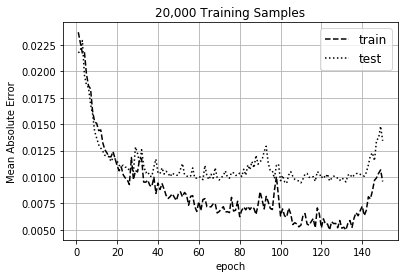

In [28]:
# # Data for plotting
# fig, ax = plt.subplots()
# ax.plot(epoch_plot, rec_loss,  'k--', label='train')
# ax.plot(epoch_plot, eval_loss,  'k:', label='test')


# legend = ax.legend(loc='upper right', fontsize='large')

# ax.set(xlabel='epoch', ylabel='Mean Absolute Error',
#         title='20,000 Training Samples')
# ax.grid()

# fig.savefig("test.png")
# plt.show()

In [26]:
train_inj_plot = train_x * 200
train_inj_plot[:, :, 1 ,1] = train_inj_plot[:, :, 0, 1]
train_inj_plot[:, :, 2 ,1] = train_inj_plot[:, :, 0, 1]
test_inj_plot = test_x * 200
test_inj_plot[:, :, 1 ,1] = test_inj_plot[:, :, 0, 1]
test_inj_plot[:, :, 2 ,1] = test_inj_plot[:, :, 0, 1]

## Train simulation results

In [49]:
print(sat_pred_train.shape)
print(train_y[:1000,...].shape)

err = np.abs(sat_pred_train - train_y[:1000,:,:,[0]])
rel_err = np.sum(err, axis=(1,2,3)) / np.sum(train_y[:1000,:,:,[0]], axis=(1,2,3))
print(rel_err.shape)
print(np.mean(rel_err))

(1000, 128, 128, 1)
(1000, 128, 128, 1)
(1000,)
0.06545571497150536


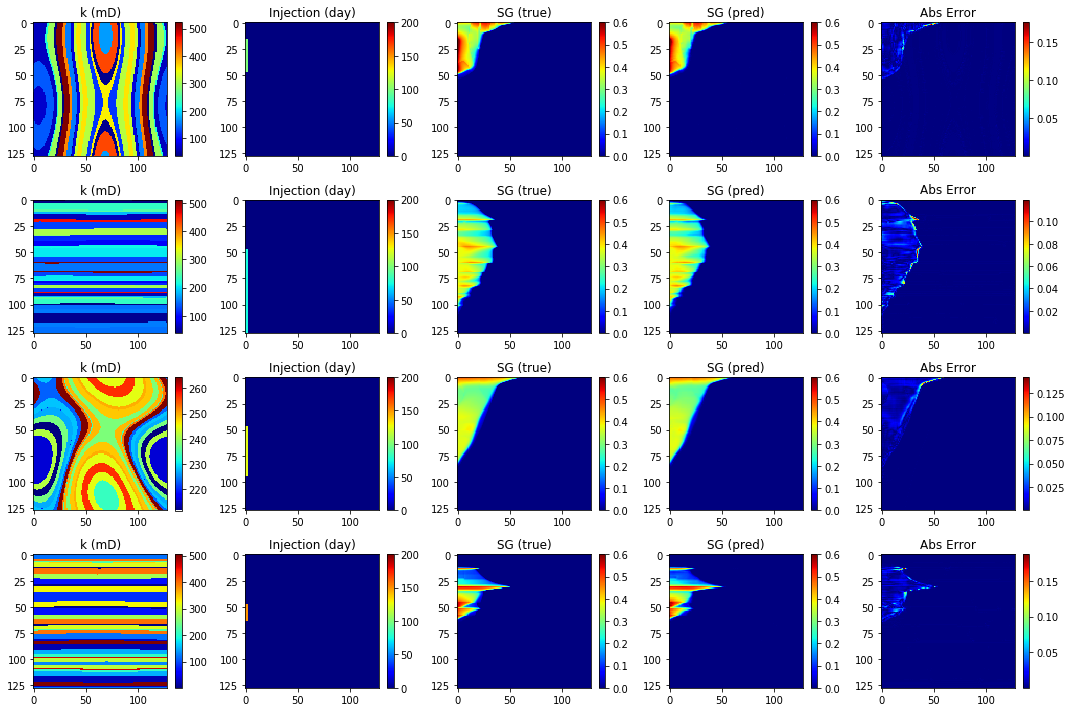

In [38]:
n_plot_train = 4
plt.figure(figsize=(15,2.5*n_plot_train))

for k in range(0,n_plot_train):
    plt.subplot(n_plot_train,5,1+k*5)
    plt.title('k (mD)')
    plt.imshow(train_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(n_plot_train,5,2+k*5)
    plt.title('Injection (day)')
    plt.imshow(train_inj_plot[k, :, :, 1])
    plt.clim(0, 200)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(n_plot_train,5,3+k*5)
    inj = test_x[k, 1, 1, 0]*50
    plt.title('SG (true)')
    plt.imshow(train_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(n_plot_train,5,4+k*5)
    plt.imshow(sat_pred_train[k, :, :, 0].reshape(128, 128))
    plt.title('SG (pred)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(n_plot_train,5,5+k*5)
    rel_err = np.abs((sat_pred_train[k, :, :, 0] - train_y[k, :, :, 0]))
    plt.imshow(rel_err) 
    plt.title('Abs. error')
    plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.savefig("figs/vunet_train_results_%dtrain_%depoch.pdf"%(train_x.shape[0], epoch), format='pdf')
plt.show()

    

## Test simulation results

In [52]:
print(sat_pred_train.shape)
print(test_y.shape)

err_test = np.abs(sat_pred_eval - test_y[:,:,:,[0]])
rel_err_test = np.sum(err_test, axis=(1,2,3)) / np.sum(test_y[:,:,:,[0]], axis=(1,2,3))
print(rel_err_test.shape)
print(np.mean(rel_err_test))

(1000, 128, 128, 1)
(100, 128, 128, 1)
(100,)
0.0737273545537374


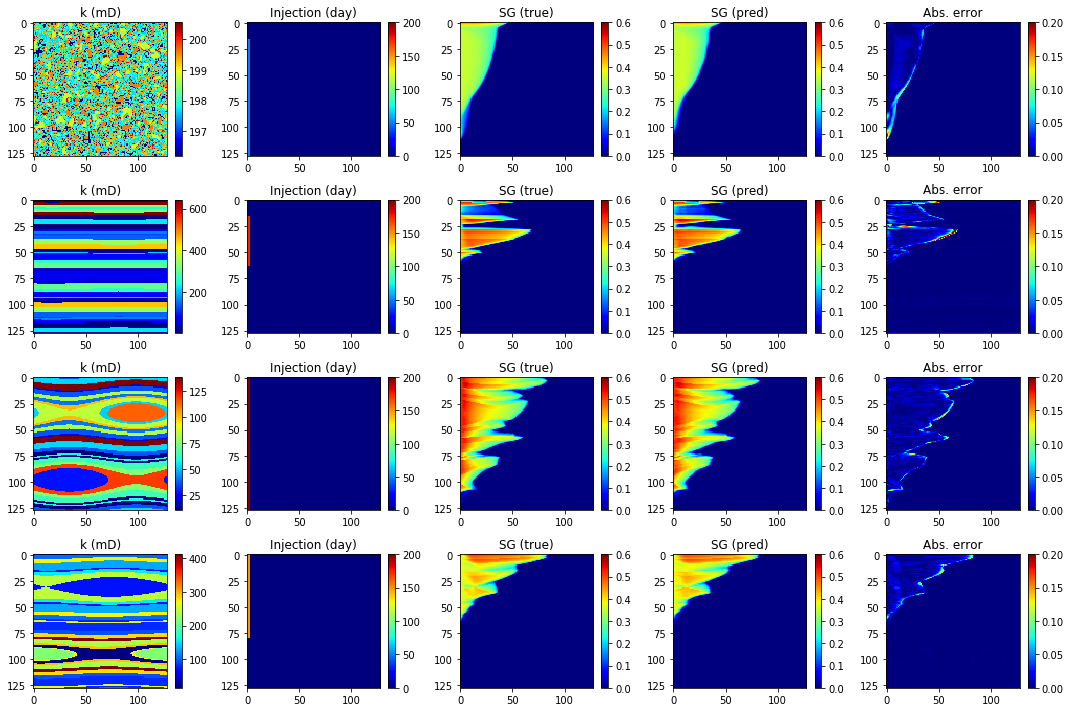

In [41]:
n_plot_test = 4
plt.figure(figsize=(15,2.5*n_plot_test))

for k in range(0,n_plot_test):
    plt.subplot(n_plot_test,5,1+k*5)
    plt.title('k (mD)')
    plt.imshow(test_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(n_plot_test,5,2+k*5)
    plt.title('Injection (day)')
    plt.imshow(test_inj_plot[k, :, :, 1])
    plt.clim(0, 200)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(n_plot_test,5,3+k*5)
    inj = test_x[k, 1, 1, 0]*50
    plt.title('SG (true)')
    plt.imshow(test_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(n_plot_test,5,4+k*5)
    plt.imshow(sat_pred_eval[k, :, :, 0].reshape(128, 128))
    plt.title('SG (pred)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(n_plot_test,5,5+k*5)
    abs_err = np.abs((sat_pred_eval[k, :, :, 0] - test_y[k, :, :, 0]))
    plt.imshow(abs_err) 
    plt.title('Abs. error')
    plt.colorbar(fraction=0.046)
    plt.clim([0, 0.2])
plt.tight_layout()
plt.savefig("figs/vunet_test_results_%dtrain_%depoch.pdf"%(train_x.shape[0], epoch), format='pdf')
plt.show()

    